Train Neural Networks to estimate Likelihood Ratios
===

In this notebook we will setup the neural networks that train unbiased and low-variance density ratios to be then used for inference. The statistical model we have is: 

$$p(x|\mu, \alpha) = \frac{1}{\nu(\mu, \alpha)} \sum_c f_c(\mu) \cdot \nu_c(\alpha) \cdot p_c\left(x|\alpha\right)$$

where $c$ stands for the various physics channels that contribute to the final state $x$, $\mu$ is the signal-strength parameter and $\alpha$ is the vector of nuisance parameters associated with the various systematic uncertainties in the model. Note that we are assuming that the parameter $\mu$-dependence is known analytically and that we have simulation models for each of the channels $p_c(x)$. 

The objective is to build the test statistic for composite hypothesis testing:

$$t_\mu = -2 \ln \frac{p(x|\mu, \hat{\hat{\alpha}})}{p(x|\hat{\mu}, \hat{\alpha})}$$

A direct approach would then be to model the probability density $p(x|\mu, \alpha)$ using NNs. But that is a more difficult task than training probability density ratios. We use a simple trick:

$$t_\mu = -2 \ln \frac{p(x|\mu, \hat{\hat{\alpha}})/p_{ref}(x)}{p(x|\hat{\mu}, \hat{\alpha})/p_{ref}(x)}$$

to turn this into a density ratio estimation problem:

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\nu(\mu, \alpha)} \sum_c f_c(\mu) \cdot \nu_c(\alpha) \cdot \frac{p_c\left(x|\alpha\right)}{p_{ref}(x)}$$

Furthermore, instead of training NNs parameterized on $\mu$ and $\alpha$, we use analytical parameterizations to simplify the problem

In [2]:
import os, sys, importlib
sys.path.append('../')

import common_utils
from common_utils import plotting, training
from common_utils.training import TrainEvaluate_NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt

hep.style.use(hep.style.ATLAS)

/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:10: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-02-11 23:13:42.065682: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-11 23:13:42.843708: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Load the datasets from pre-processed input
saved_data='./cached_data/'

training_features = np.load(f"{saved_data}features.npy")
train_labels = np.load(f"{saved_data}train_labels.npy")
preselection_score = np.load(f"{saved_data}preselection_score.npy")
weights = np.load(f"{saved_data}weights.npy")

In [4]:
# labels_dict = {"ttbar": 0,
#                "single_top_s_chan":1,
#               "single_top_t_chan":2,
#               "single_top_tW":3,
#               "wjets":4}

# Keep only a subset of the background for illustration
labels_dict = {"ttbar": 0,
              "single_top_t_chan":1,
              "wjets":2}

In [5]:
min_pred = np.amin(preselection_score)
max_pred = np.amax(preselection_score)

bins = np.linspace(min_pred, max_pred, num=150)

hist_NN_output = {}

for key in labels_dict: 
    hist_NN_output[key], _ = np.histogram(preselection_score[train_labels==labels_dict[key]], weights = weights[train_labels==labels_dict[key]], bins=bins)


Make a selection cut for performing the NSBI analysis, balancing the number of signal events that go into the signal region (increasing sensitivity) and the feasibility of training accurate and precise NNs over a large phase space (need bigger models and more statistics).

As a first cut, we choose a loose preselection and see if it works.

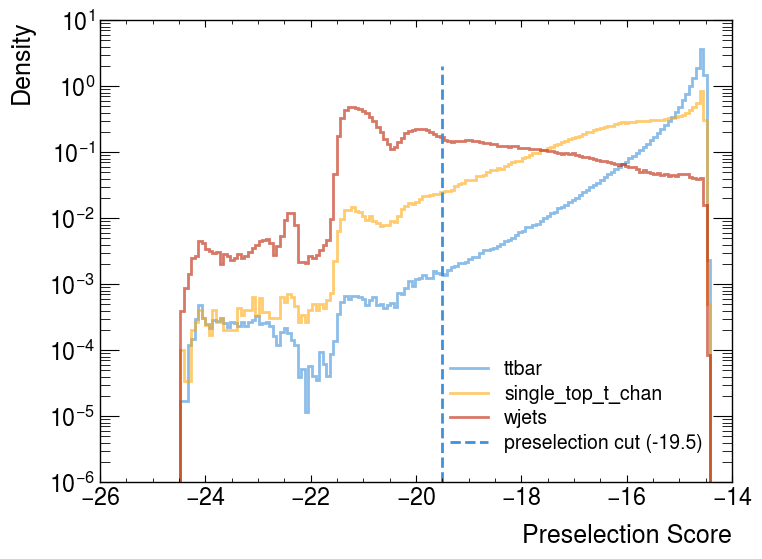

In [6]:
preselection_cut = -19.5 # Lets start with a very loose cut

for key in labels_dict:  
    hep.histplot(hist_NN_output[key], bins=bins, 
             alpha=0.6, label=key, 
             density=True, linewidth=2.0)

plt.xlabel("Preselection Score", size=18)
plt.axvline(preselection_cut, ymax=0.9, linestyle='--', label=f'preselection cut ({preselection_cut})')
plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

In [7]:
# Make the preselections

training_features = training_features[preselection_score>=preselection_cut].copy()
train_labels = train_labels[preselection_score>=preselection_cut].copy()
weights = weights[preselection_score>=preselection_cut].copy()

preselection_score_selected = preselection_score[preselection_score>=preselection_cut].copy()


In [8]:
type_vec = np.array(train_labels, dtype='object')

for key in labels_dict:
    type_vec[type_vec==labels_dict[key]] = key


In [9]:
# Build a pandas dataframe from the arrays for density ratio training and validation
columns = ['lepton_pt', 'lepton_eta', 'lepton_phi', 'H_T']
dataset = pd.DataFrame(training_features, columns=columns)

dataset['log_lepton_pt'] = np.log(dataset['lepton_pt'].ravel())
dataset['log_H_T'] = np.log(dataset['H_T'].ravel()+1.0)

dataset['presel_score'] = preselection_score_selected
dataset['train_labels'] = train_labels
dataset['type'] = type_vec
dataset['weights'] = weights

In [10]:
# Normalizing the training weights - only discriminating shapes, not norms

weights_normed = weights.copy()

for key in labels_dict:

    weights_normed[train_labels==labels_dict[key]] /= weights[train_labels==labels_dict[key]].sum()

dataset['weights_normed'] = weights_normed


In [11]:
# Save the preselected dataframe for inference use later on
dataset.to_hdf(f"{saved_data}dataset_preselected_ttbar.h5", key="dataset", mode='w')


In [12]:
columns = ['lepton_pt', 'lepton_eta', 'lepton_phi']
columns_scaling = ['lepton_pt', 'lepton_eta', 'lepton_phi']

columns = ['log_lepton_pt', 'lepton_eta', 'lepton_phi']
columns_scaling = ['log_lepton_pt', 'lepton_eta', 'lepton_phi']

columns = ['log_lepton_pt', 'log_H_T', 'lepton_eta', 'lepton_phi']
columns_scaling = ['log_lepton_pt', 'log_H_T', 'lepton_eta', 'lepton_phi']

In [13]:
# Choose ttbar as the reference hypothesis
dataset_ch_wjets_ref = pd.concat([dataset[dataset['type']=='wjets'], 
                                  dataset[dataset['type']=='ttbar']])

dataset_ch_wjets_ref['train_labels'] = 0
dataset_ch_wjets_ref.loc[dataset_ch_wjets_ref['type']=='ttbar', 'train_labels'] = 1


In [14]:
NN_training_channels_dict = {}


In [15]:

rnd_seed_traintestsplit = 42
channel_names = ['wjets', 'ttbar']

# Save paths
output_dir = './output_general_wjets/'
output_name = 'first_training_wjets'
path_to_ratios = './output_ratios_wjets/'
path_to_figures = './output_figures_wjets/'
path_to_models = './output_model_params_wjets/'

importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluate_NN

# Initialize the training class
NN_training_channels_dict['wjets'] = TrainEvaluate_NN(dataset_ch_wjets_ref, 
                                                       dataset_ch_wjets_ref['weights_normed'],
                                                       dataset_ch_wjets_ref['train_labels'],
                                                       columns, 
                                                       columns_scaling, rnd_seed_traintestsplit, 
                                                       channel_names, output_dir, output_name, 
                                                        path_to_figures=path_to_figures,
                                                        path_to_ratios=path_to_ratios, 
                                                        path_to_models=path_to_models)



Sum of weights of class 0: 0.799999185730746
Sum of weights of class 1: 0.7999910844820067
Using swish activation function
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              5000      
                                                                 
 dense_1 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_2 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_3 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_4 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 3009001 (11.48 MB)
Trainable params: 3009001 (11.48

2025-02-11 23:13:58.857901: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3234 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.5gb, pci bus id: 0000:81:00.0, compute capability: 8.0


Using Callbacks
Epoch 1/70


2025-02-11 23:14:00.327891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-02-11 23:14:00.522255: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f15f4875530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-11 23:14:00.522322: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 1g.5gb, Compute Capability 8.0
2025-02-11 23:14:00.529801: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-11 23:14:00.544283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2025-02-11 23:14:00.597342: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-11 23:14

1973/1973 - 16s - loss: 1.8564e-07 - binary_accuracy: 0.9016 - val_loss: 1.7451e-07 - val_binary_accuracy: 0.9089 - lr: 0.1000 - 16s/epoch - 8ms/step
Epoch 2/70
1973/1973 - 13s - loss: 1.7428e-07 - binary_accuracy: 0.9082 - val_loss: 1.7340e-07 - val_binary_accuracy: 0.9092 - lr: 0.1000 - 13s/epoch - 7ms/step
Epoch 3/70
1973/1973 - 13s - loss: 1.7275e-07 - binary_accuracy: 0.9083 - val_loss: 1.7312e-07 - val_binary_accuracy: 0.9078 - lr: 0.1000 - 13s/epoch - 7ms/step
Epoch 4/70
1973/1973 - 13s - loss: 1.7139e-07 - binary_accuracy: 0.9085 - val_loss: 1.7243e-07 - val_binary_accuracy: 0.9079 - lr: 0.1000 - 13s/epoch - 7ms/step
Epoch 5/70
1973/1973 - 13s - loss: 1.7103e-07 - binary_accuracy: 0.9086 - val_loss: 1.7002e-07 - val_binary_accuracy: 0.9098 - lr: 0.1000 - 13s/epoch - 7ms/step
Epoch 6/70
1973/1973 - 13s - loss: 1.7082e-07 - binary_accuracy: 0.9087 - val_loss: 1.7069e-07 - val_binary_accuracy: 0.9087 - lr: 0.1000 - 13s/epoch - 7ms/step
Epoch 7/70
1973/1973 - 13s - loss: 1.7047e-07

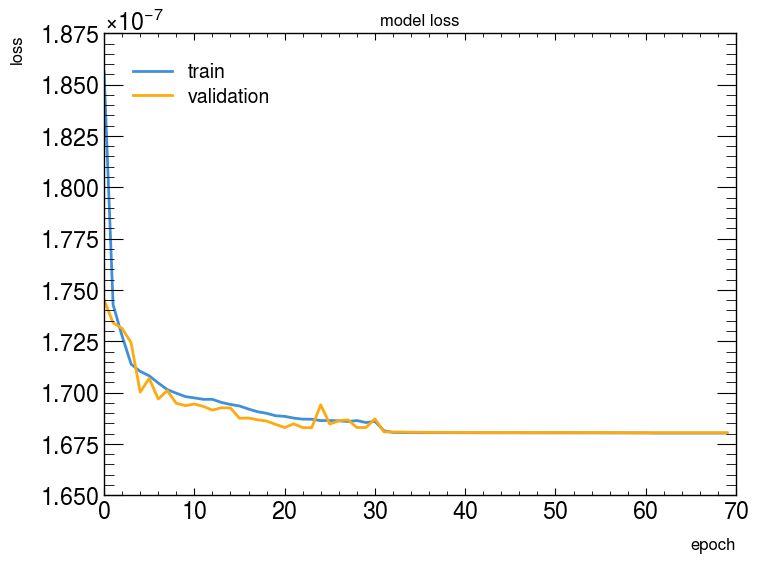

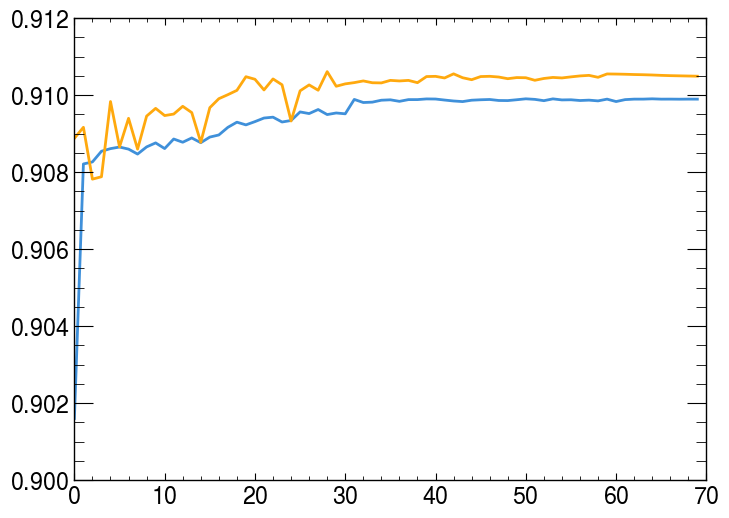

1536/1536 - 1s - 1s/epoch - 678us/step
16001/16001 - 10s - 10s/epoch - 614us/step
6141/6141 - 4s - 4s/epoch - 613us/step
64002/64002 - 39s - 39s/epoch - 613us/step
ttbar training data prediction (max) = 0.9913017
ttbar training data prediction (min) = 0.002393272
wjets training data prediction (max) = 0.99194735
wjets training data prediction (min) = 0.002584089
ttbar training data prediction (max) = 0.9912872
ttbar training data prediction (min) = 0.0024512992
wjets training data prediction (max) = 0.991803
wjets training data prediction (min) = 0.0028450314


<Figure size 800x600 with 0 Axes>

In [16]:
# Train the density ratio NN
NN_training_channels_dict['wjets'].train(hidden_layers=4, 
                        neurons=1000, 
                        number_of_epochs=70, 
                        batch_size=1024, 
                        learning_rate=0.1, 
                        scalerType='MinMax', 
                        calibration=False, 
                        num_bins_cal = 10, 
                        callback=True, 
                        callback_patience=30, 
                        callback_factor=0.01)    


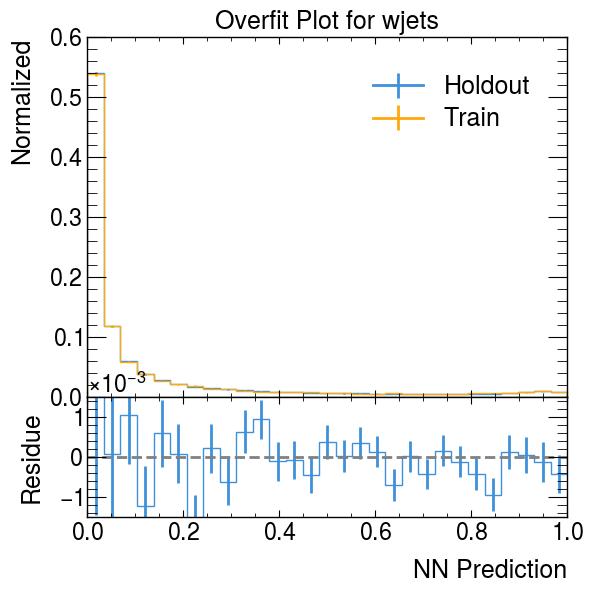

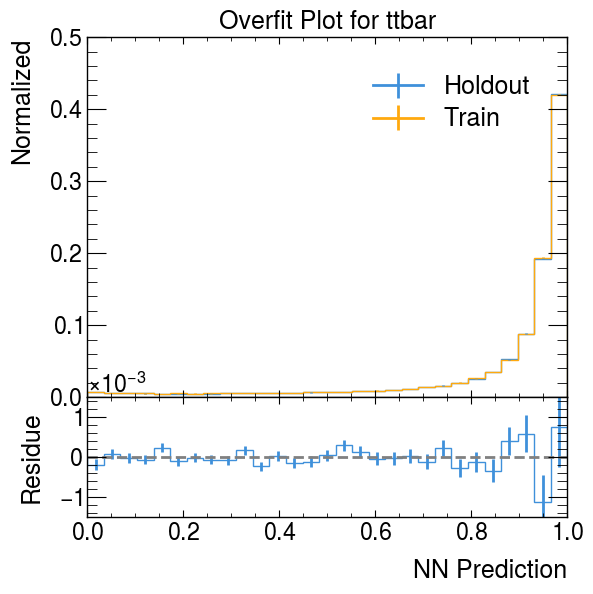

<Figure size 800x600 with 0 Axes>

In [17]:
NN_training_channels_dict['wjets'].make_overfit_plots()

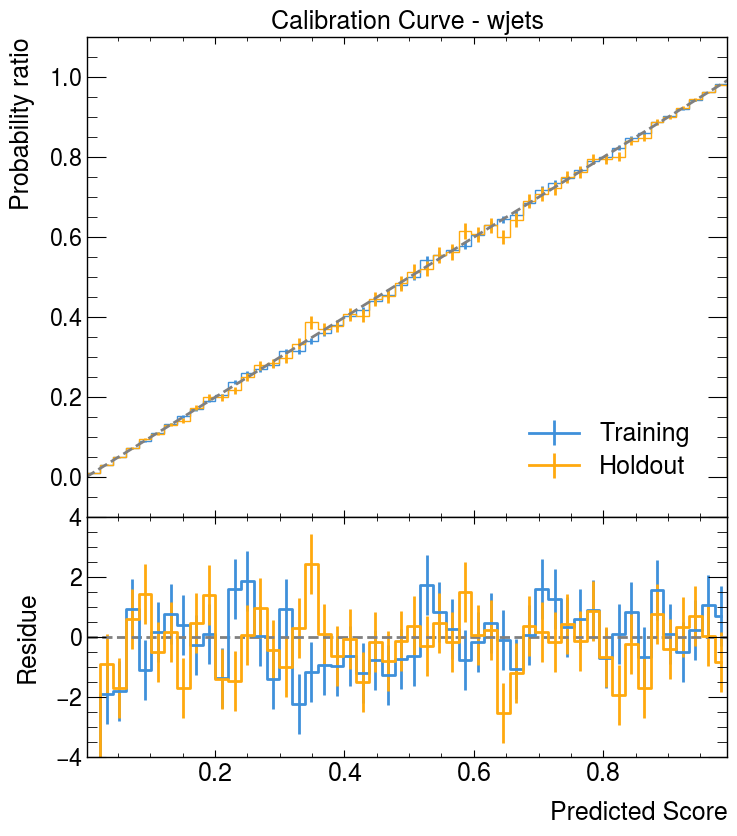

observable not recognized


<Figure size 800x600 with 0 Axes>

In [18]:
num_bins_cal = 50
NN_training_channels_dict['wjets'].make_calib_plots(nbins=num_bins_cal, observable='score')

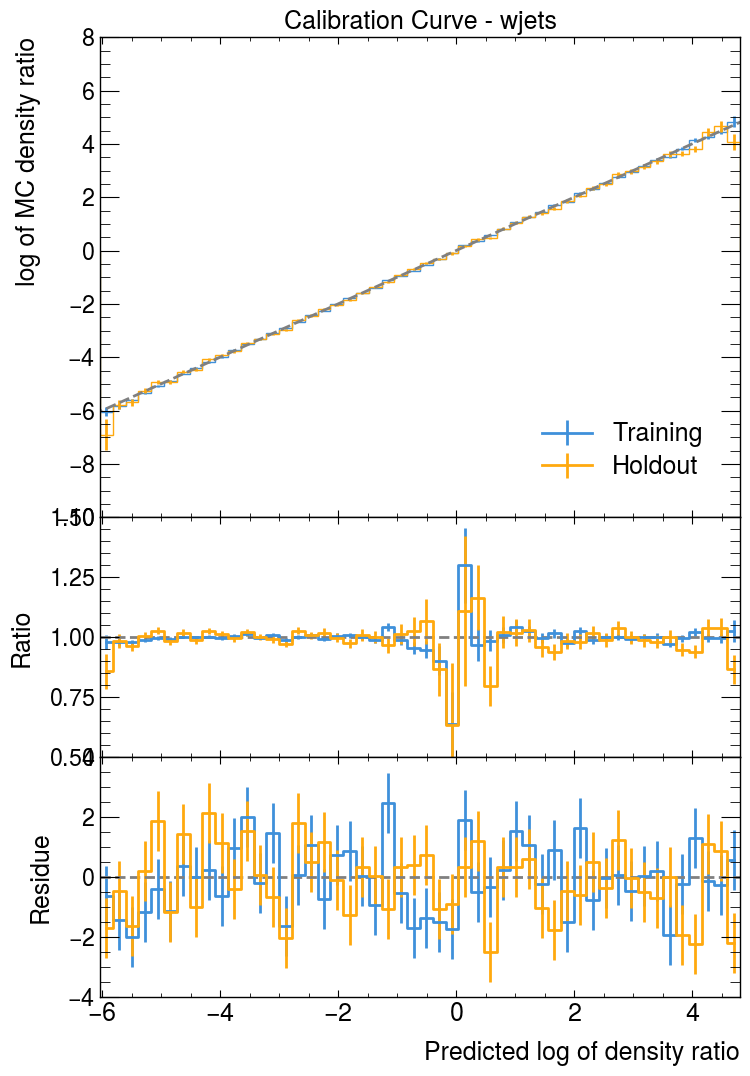

<Figure size 800x600 with 0 Axes>

In [19]:
num_bins_cal = 50
NN_training_channels_dict['wjets'].make_calib_plots(nbins=num_bins_cal, observable='llr')

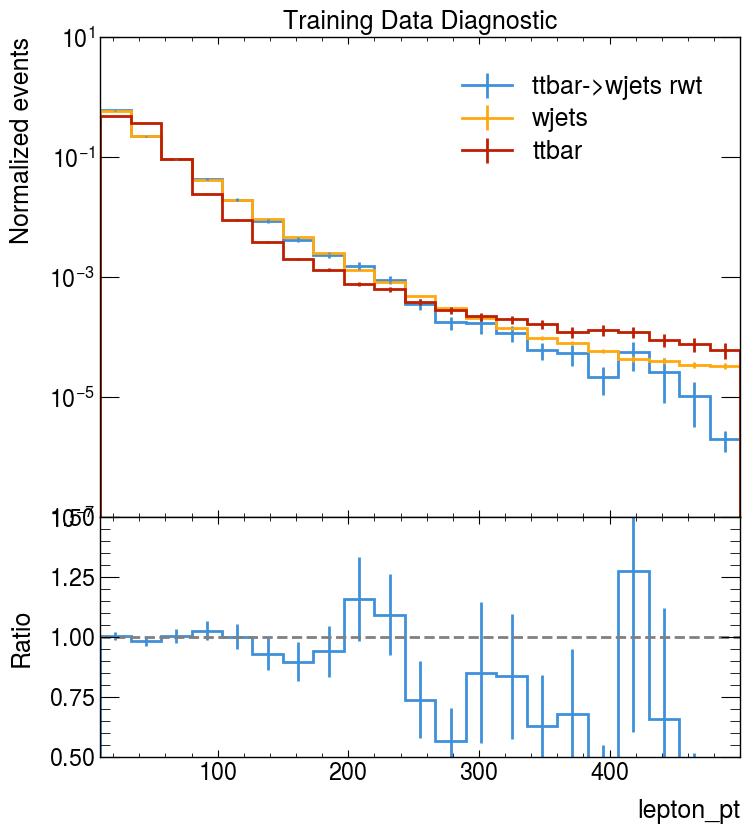

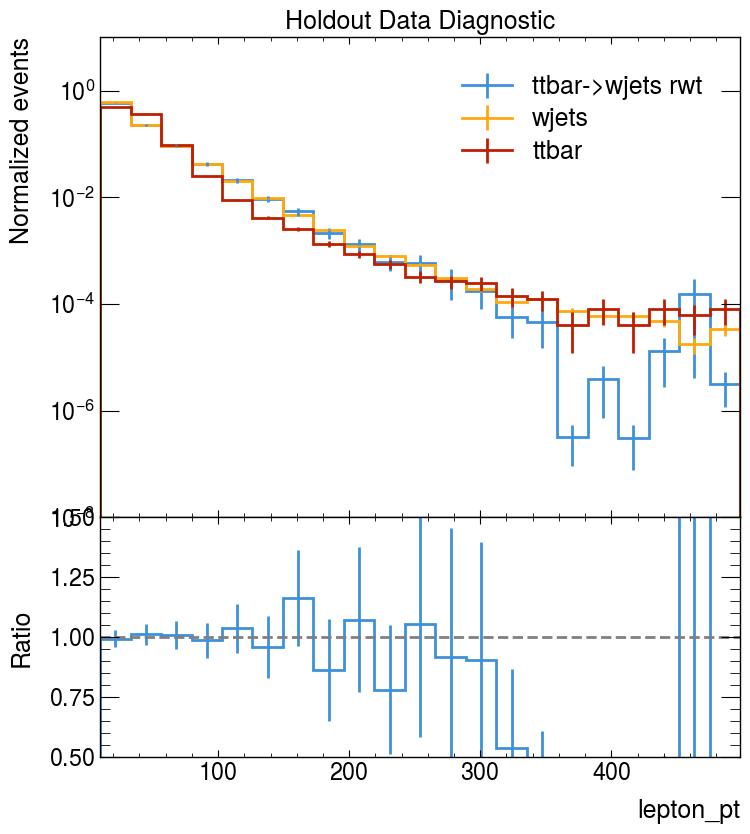

<Figure size 800x600 with 0 Axes>

In [20]:
variables_to_plot=['lepton_pt']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


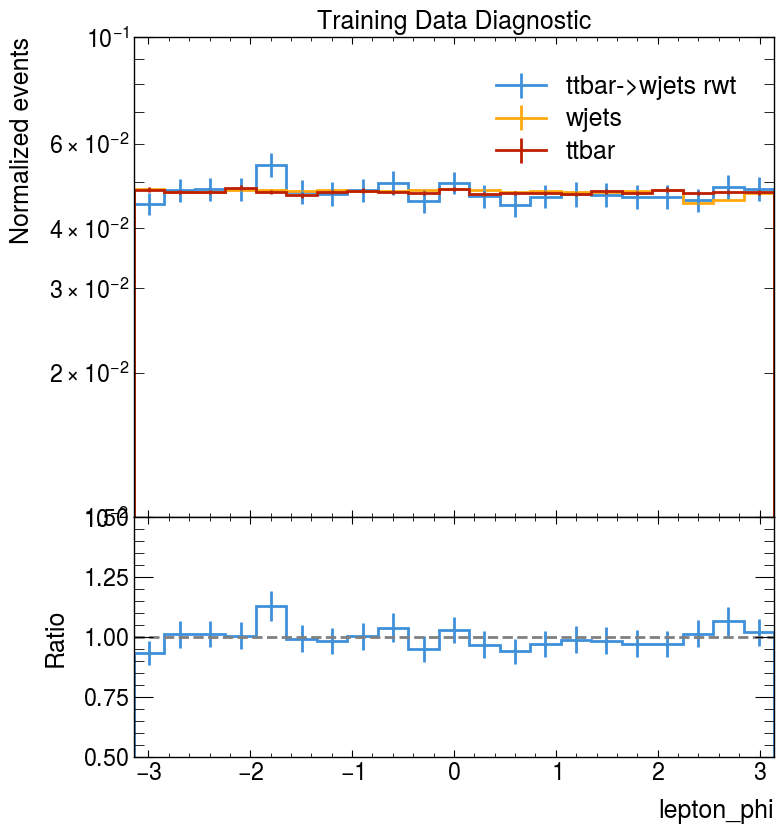

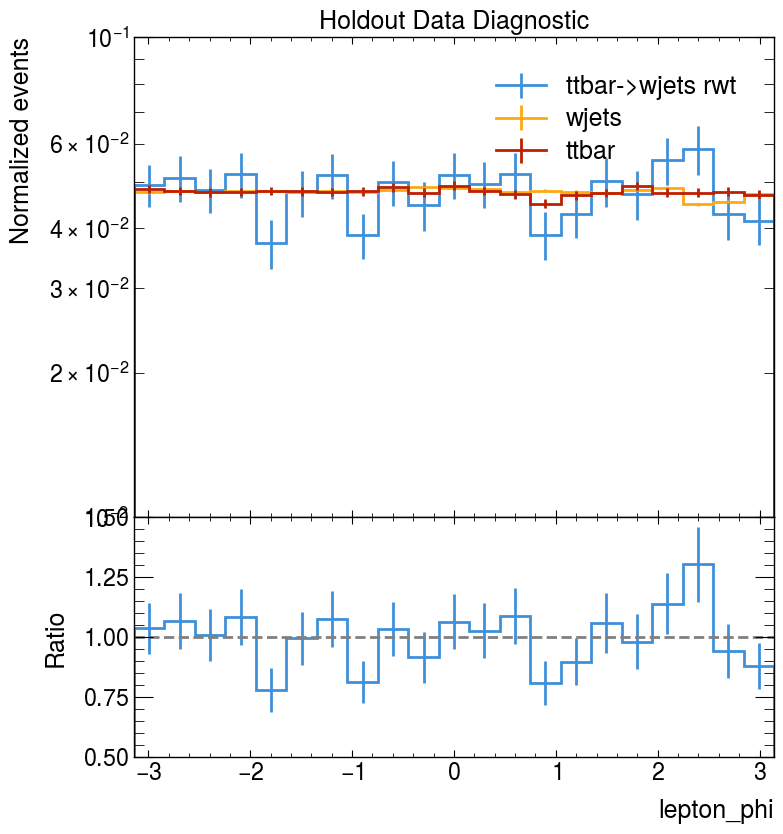

<Figure size 800x600 with 0 Axes>

In [21]:
variables_to_plot=['lepton_phi']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


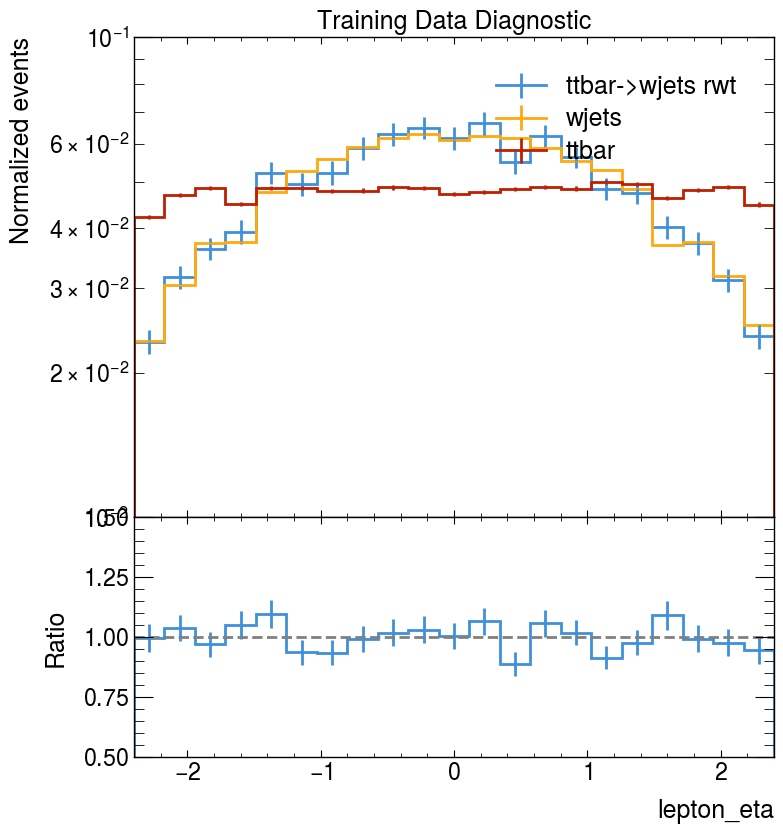

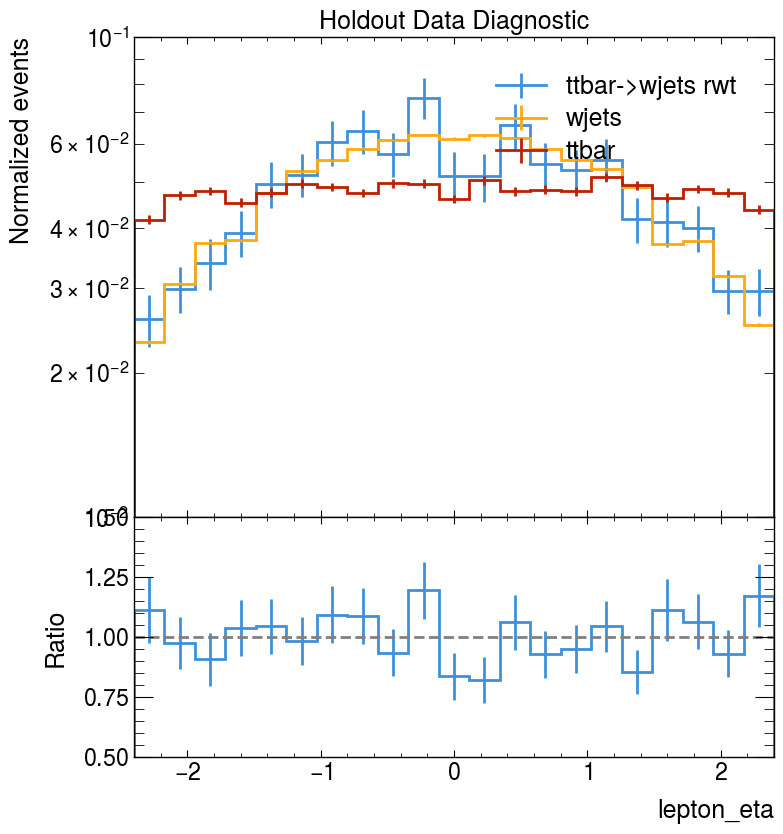

<Figure size 800x600 with 0 Axes>

In [22]:
variables_to_plot=['lepton_eta']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:281: RuntimeWarning: invalid value encountered in divide
  hep.histplot(rat, edges, yerr = np.abs(rat*np.sqrt((np.sqrt(hist_den_err)/hist_den)**2+(np.sqrt(hist_num_err)/hist_num)**2)), linewidth=2.0)


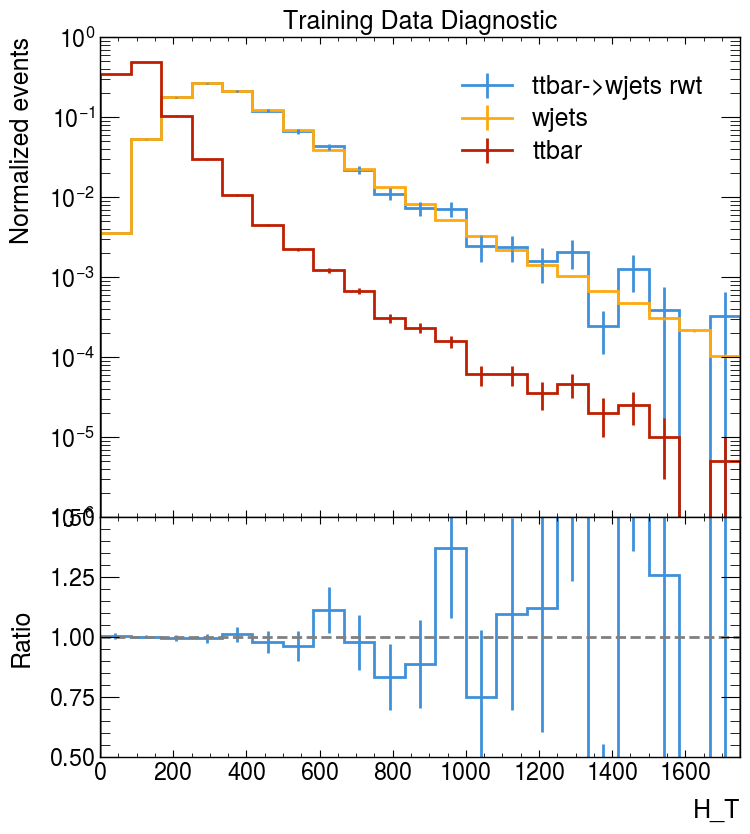

/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:281: RuntimeWarning: invalid value encountered in divide
  hep.histplot(rat, edges, yerr = np.abs(rat*np.sqrt((np.sqrt(hist_den_err)/hist_den)**2+(np.sqrt(hist_num_err)/hist_num)**2)), linewidth=2.0)


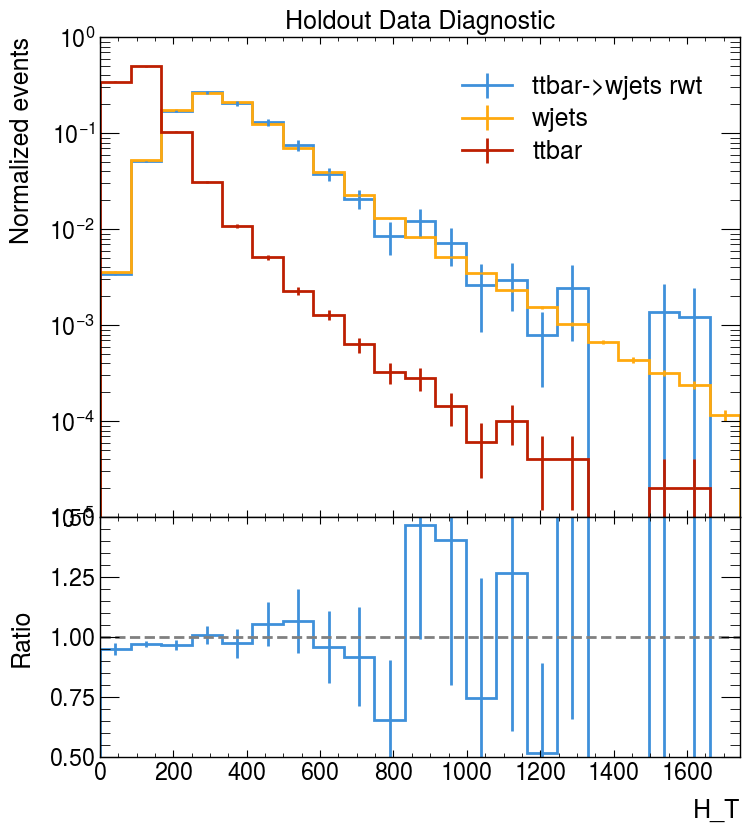

<Figure size 800x600 with 0 Axes>

In [23]:
variables_to_plot=['H_T']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


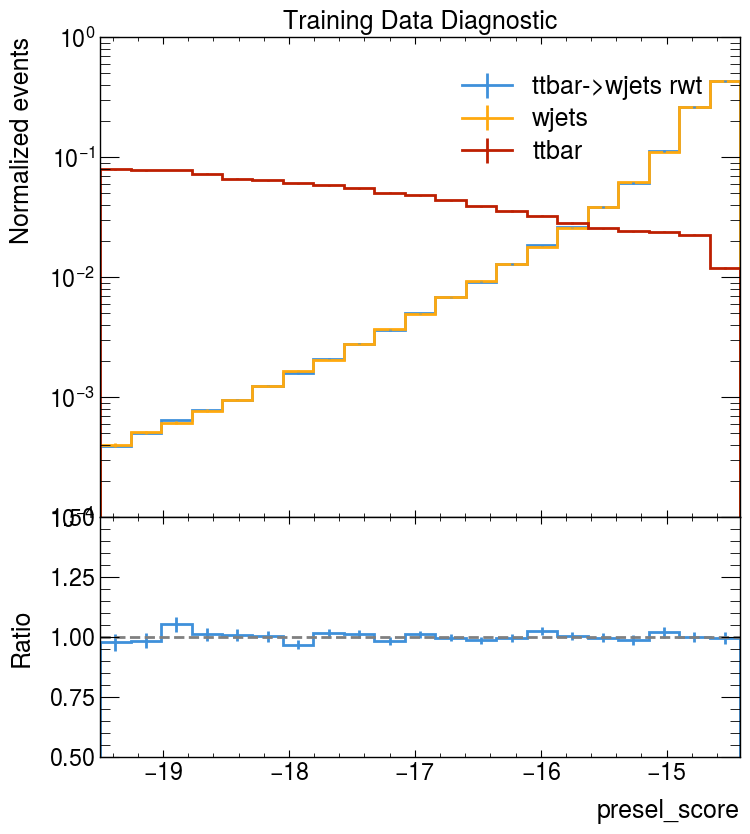

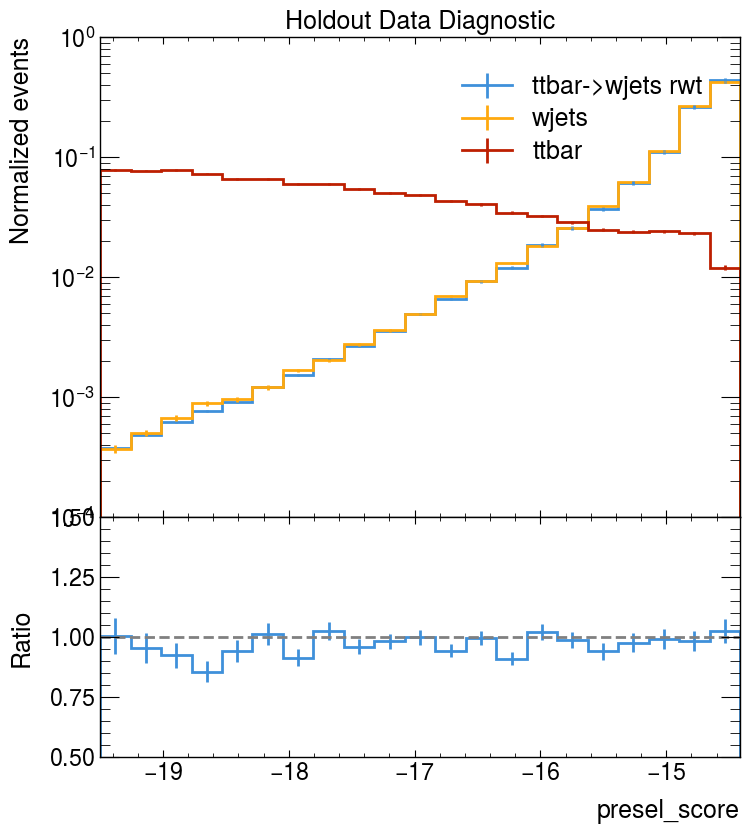

<Figure size 800x600 with 0 Axes>

In [37]:
variables_to_plot=['presel_score']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [24]:
NN_training_channels_dict['wjets'].evaluate_and_save_ratios(dataset)


100915/100915 - 61s - 61s/epoch - 601us/step


In [25]:
# Choose ttbar as the reference hypothesis
dataset_ch_single_top_t_chan_ref = pd.concat([dataset[dataset['type']=='single_top_t_chan'], 
                                  dataset[dataset['type']=='ttbar']])

dataset_ch_single_top_t_chan_ref['train_labels'] = 0
dataset_ch_single_top_t_chan_ref.loc[dataset_ch_single_top_t_chan_ref['type']=='ttbar', 'train_labels'] = 1


In [26]:

rnd_seed_traintestsplit = 42
channel_names = ['single_top_t_chan', 'ttbar']

# Save paths
output_dir = './output_general_singletop/'
output_name = 'first_training_singletop'
path_to_ratios = './output_ratios_singletop/'
path_to_figures = './output_figures_singletop/'
path_to_models = './output_model_params_singletop/'



importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluate_NN

# Initialize the training class
NN_training_channels_dict['singletop'] = TrainEvaluate_NN(dataset_ch_single_top_t_chan_ref, 
                               dataset_ch_single_top_t_chan_ref['weights_normed'],
                               dataset_ch_single_top_t_chan_ref['train_labels'],
                               columns, 
                               columns_scaling, rnd_seed_traintestsplit, 
                               channel_names, output_dir, output_name, 
                                path_to_figures=path_to_figures,
                                path_to_ratios=path_to_ratios, 
                                path_to_models=path_to_models)



Sum of weights of class 0: 0.8000009443606325
Sum of weights of class 1: 0.8000035328165155
Using swish activation function
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1000)              5000      
                                                                 
 dense_6 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_7 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_8 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_9 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 3009001 (11.48 MB)
Trainable params: 3009001 (11

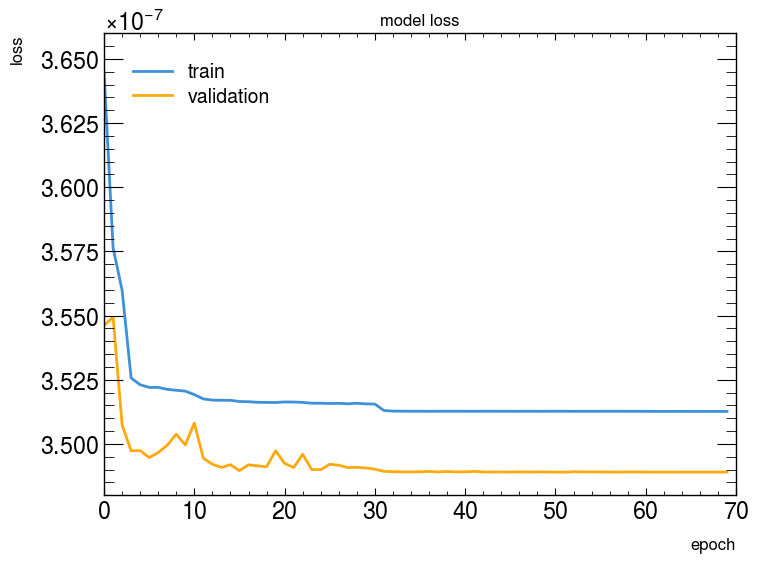

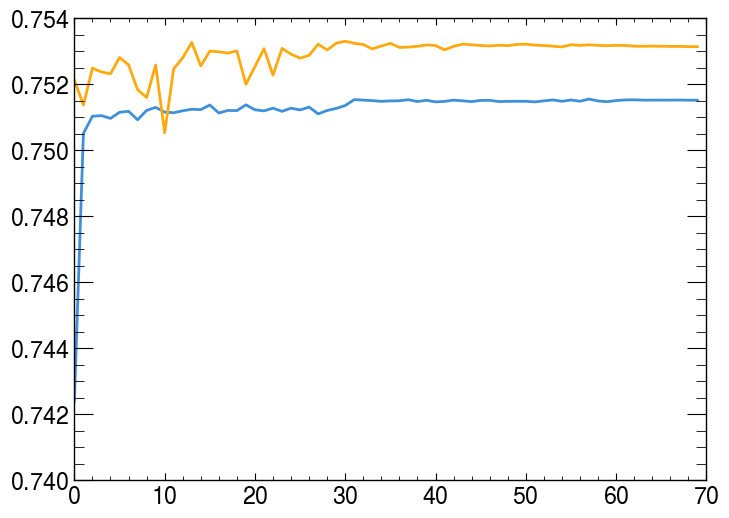

2648/2648 - 2s - 2s/epoch - 620us/step
16001/16001 - 10s - 10s/epoch - 602us/step
10590/10590 - 6s - 6s/epoch - 612us/step
64002/64002 - 39s - 39s/epoch - 604us/step
ttbar training data prediction (max) = 0.86362755
ttbar training data prediction (min) = 0.031590525
single_top_t_chan training data prediction (max) = 0.8672491
single_top_t_chan training data prediction (min) = 0.034230713
ttbar training data prediction (max) = 0.8616042
ttbar training data prediction (min) = 0.034737773
single_top_t_chan training data prediction (max) = 0.8666132
single_top_t_chan training data prediction (min) = 0.039183483


<Figure size 800x600 with 0 Axes>

In [27]:
# Train the density ratio NN
NN_training_channels_dict['singletop'].train(hidden_layers=4, 
                        neurons=1000, 
                        number_of_epochs=70, 
                        batch_size=1024, 
                        learning_rate=0.1, 
                        scalerType='MinMax', 
                        calibration=False, 
                        num_bins_cal = 10, 
                        callback=True, 
                        callback_patience=30, 
                        callback_factor=0.01)    


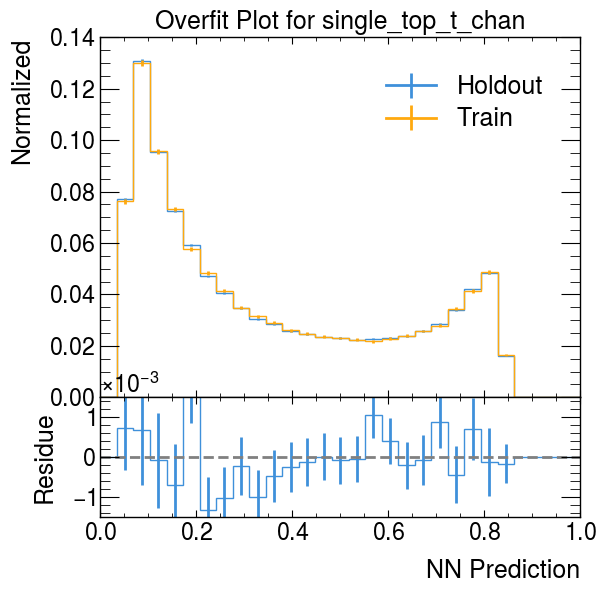

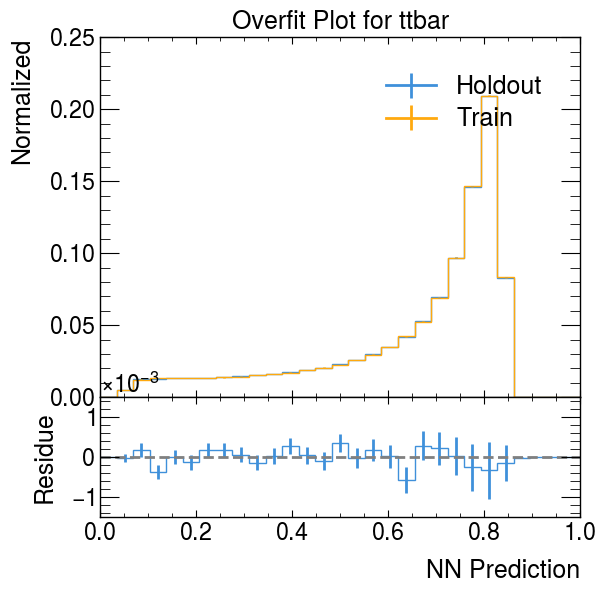

<Figure size 800x600 with 0 Axes>

In [28]:
NN_training_channels_dict['singletop'].make_overfit_plots()

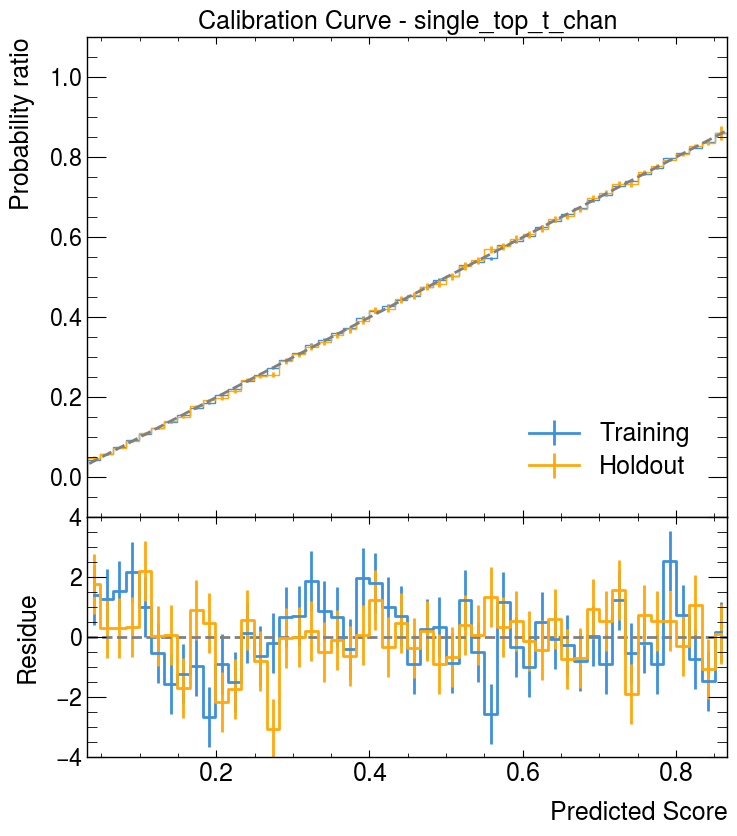

observable not recognized


<Figure size 800x600 with 0 Axes>

In [29]:
num_bins_cal = 50
NN_training_channels_dict['singletop'].make_calib_plots(nbins=num_bins_cal, observable='score')

/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:162: RuntimeWarning: invalid value encountered in divide
  h_log_holdout = np.log(hist_num_holdout/hist_den_holdout)
/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:162: RuntimeWarning: divide by zero encountered in log
  h_log_holdout = np.log(hist_num_holdout/hist_den_holdout)
/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:163: RuntimeWarning: invalid value encountered in divide
  h_log_holdout_err = np.sqrt((hist_num_holdout_err/hist_num_holdout**2)+(hist_den_holdout_err/hist_den_holdout**2))


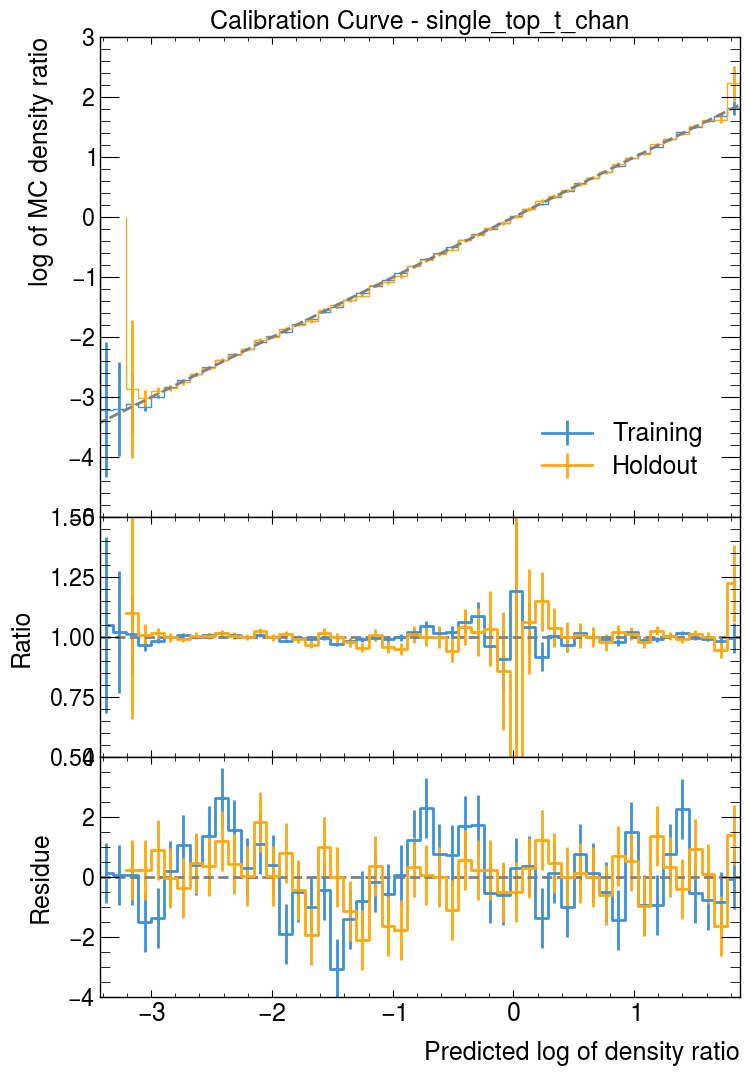

<Figure size 800x600 with 0 Axes>

In [30]:
NN_training_channels_dict['singletop'].make_calib_plots(nbins=num_bins_cal, observable='llr')


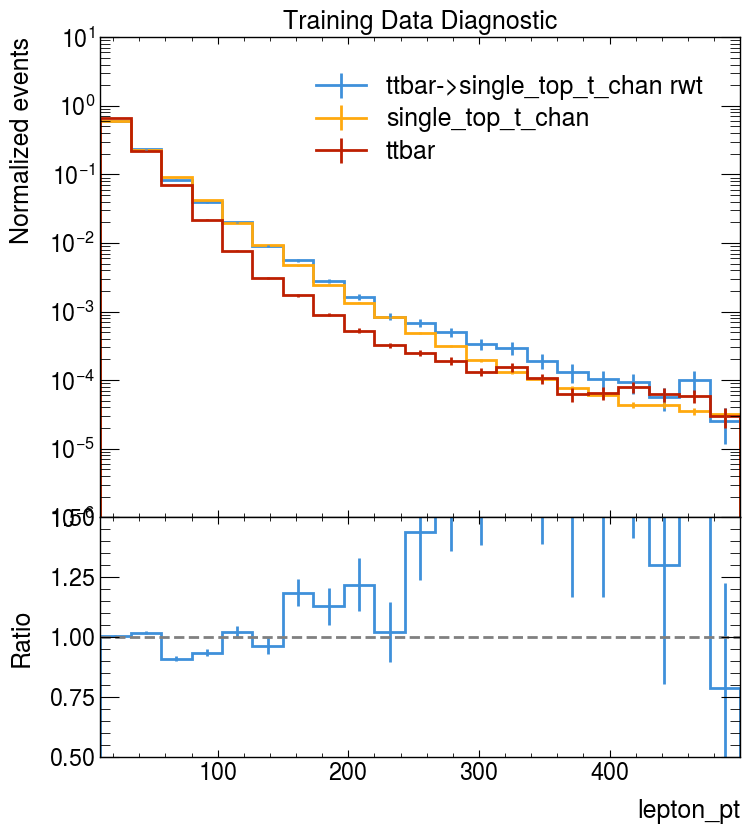

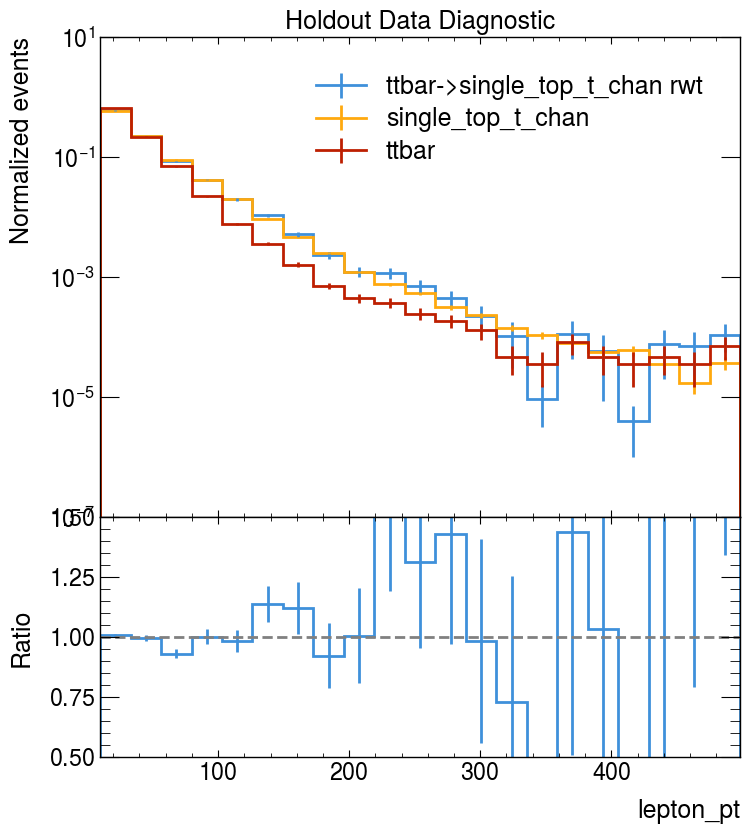

<Figure size 800x600 with 0 Axes>

In [31]:
variables_to_plot=['lepton_pt']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


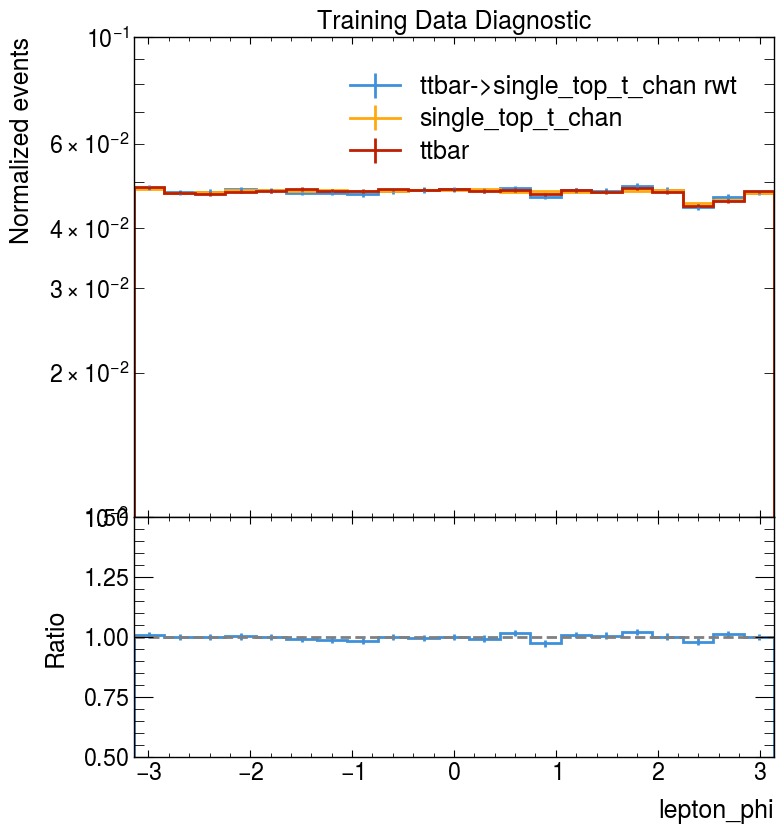

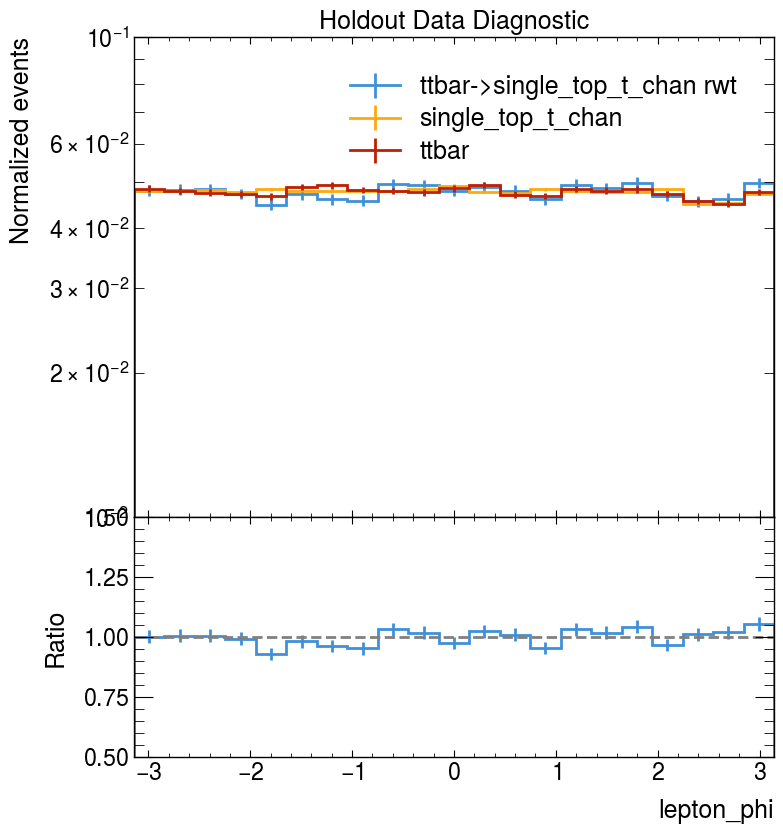

<Figure size 800x600 with 0 Axes>

In [32]:
variables_to_plot=['lepton_phi']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


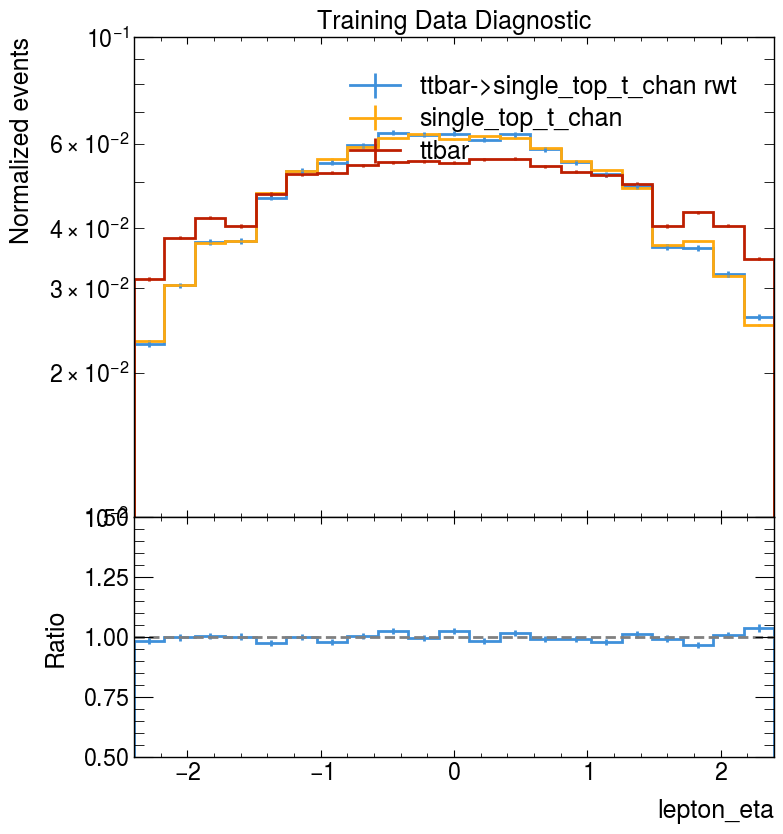

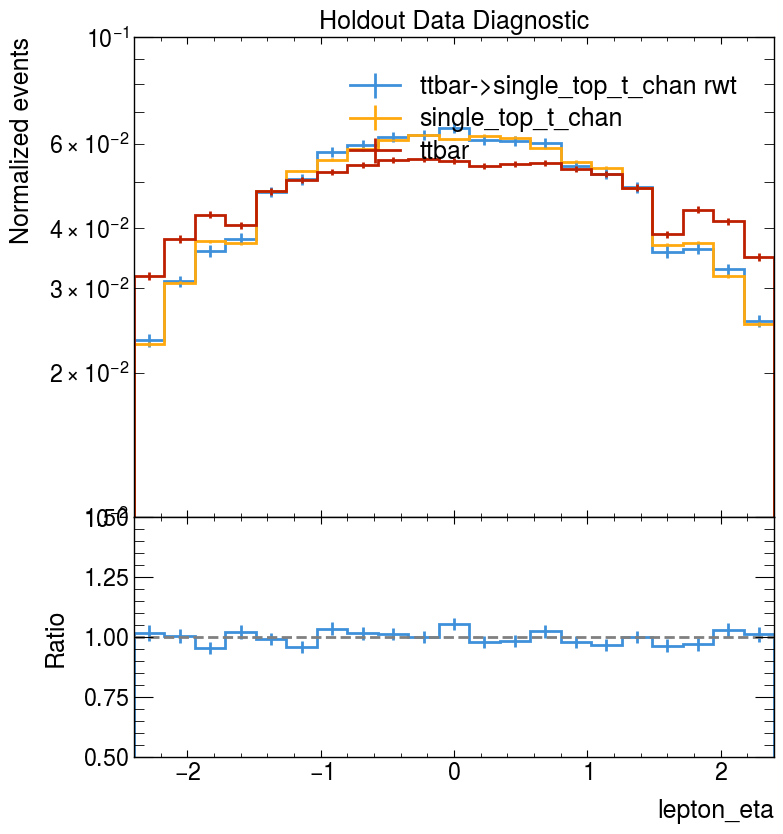

<Figure size 800x600 with 0 Axes>

In [33]:
variables_to_plot=['lepton_eta']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


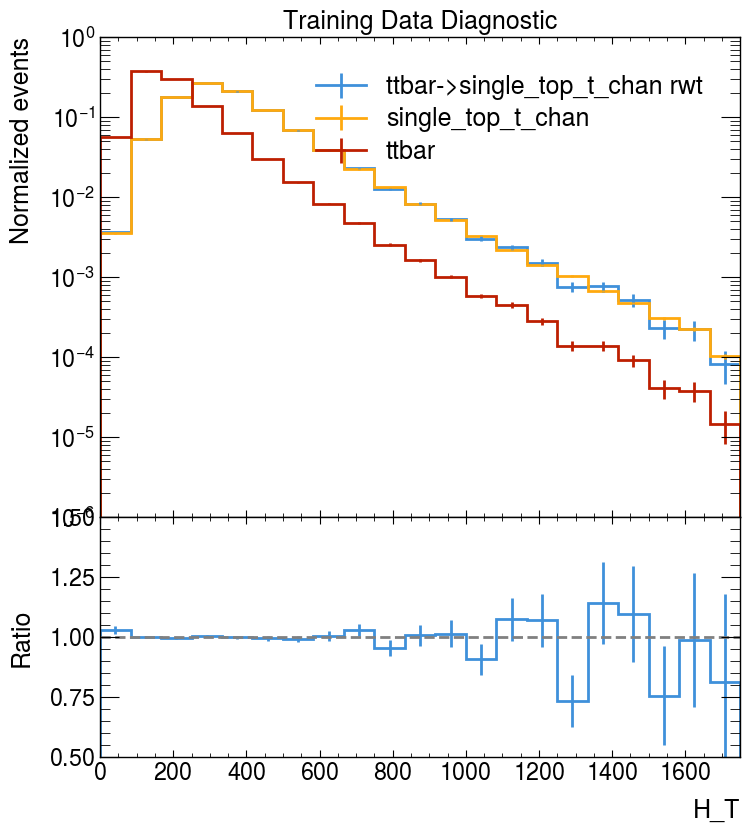

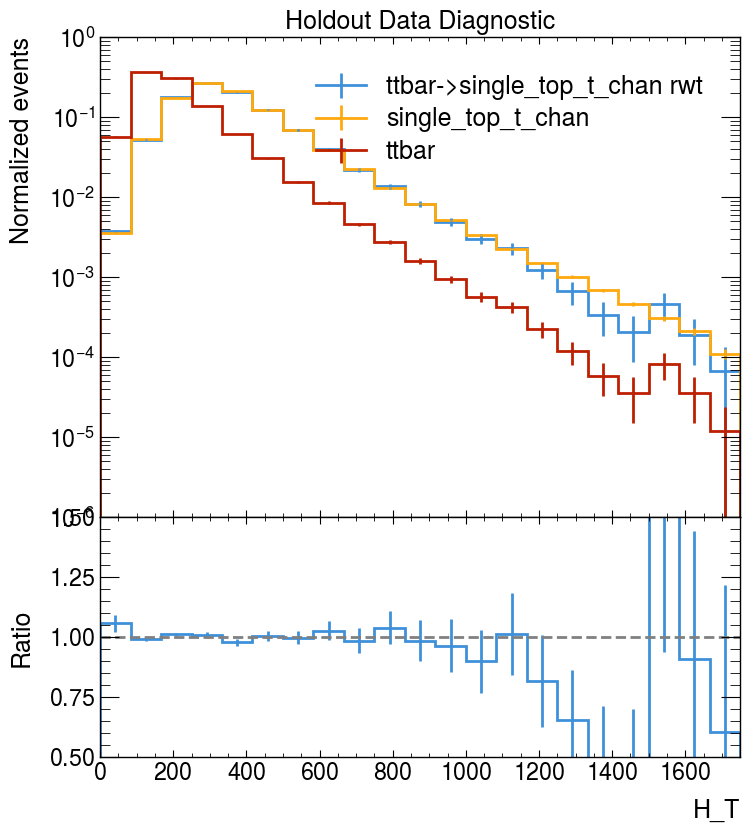

<Figure size 800x600 with 0 Axes>

In [34]:
variables_to_plot=['H_T']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


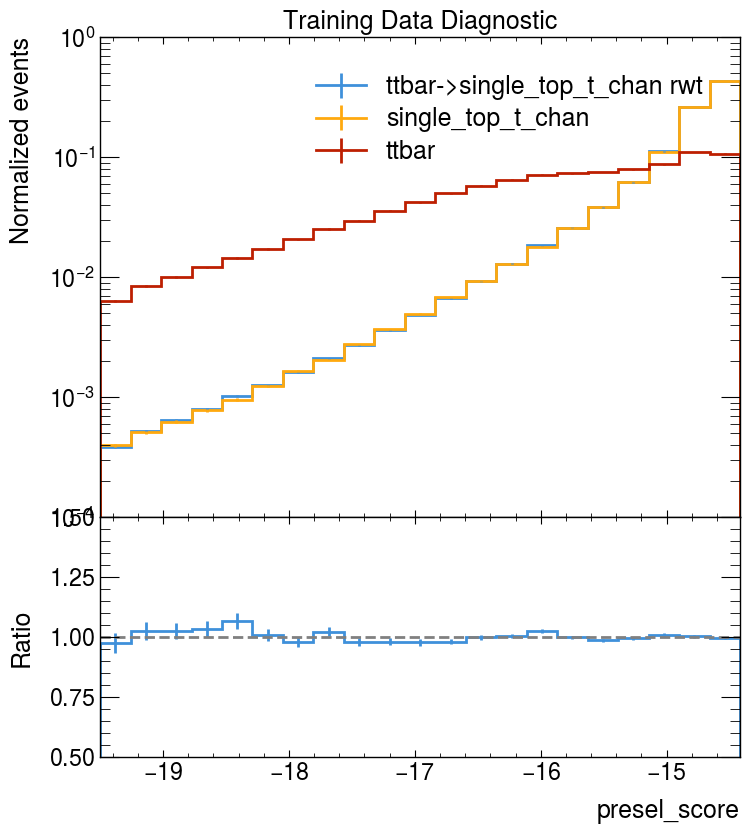

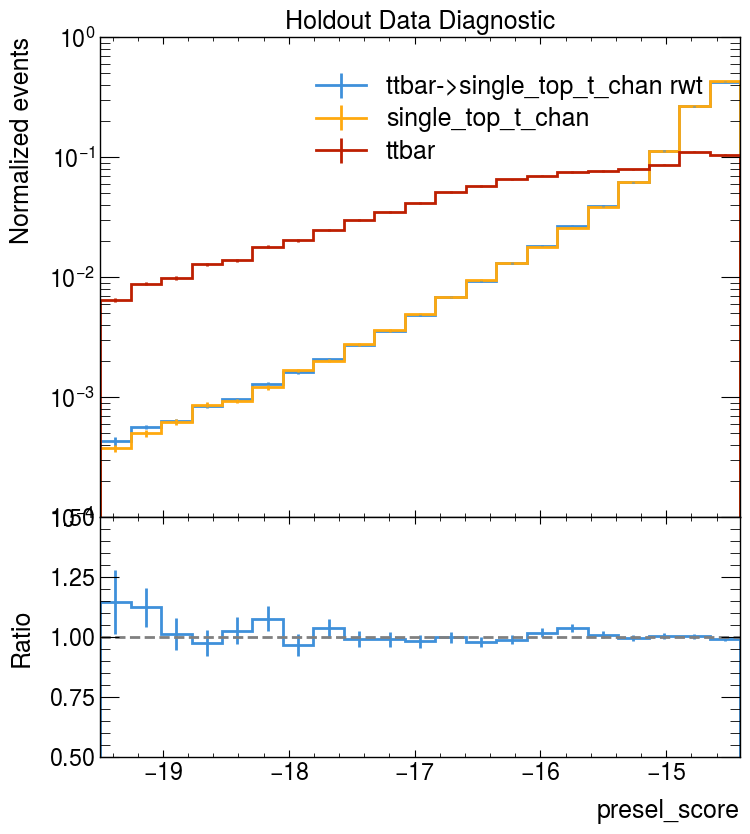

<Figure size 800x600 with 0 Axes>

In [38]:
variables_to_plot=['presel_score']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [35]:
NN_training_channels_dict['singletop'].evaluate_and_save_ratios(dataset)


100915/100915 - 61s - 61s/epoch - 601us/step


In [36]:
# backup code for updating class methods 
importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluate_NN
import types

NN_training_channels_dict['wjets'].make_reweighted_plots = types.MethodType(TrainEvaluate_NN.make_reweighted_plots, NN_training_channels_dict['wjets'])
NN_training_channels_dict['wjets'].make_calib_plots = types.MethodType(TrainEvaluate_NN.make_calib_plots, NN_training_channels_dict['wjets'])
NN_training_channels_dict['wjets'].evaluate_and_save_ratios = types.MethodType(TrainEvaluate_NN.evaluate_and_save_ratios, NN_training_channels_dict['wjets'])
NN_training_channels_dict['wjets'].make_overfit_plots = types.MethodType(TrainEvaluate_NN.make_overfit_plots, NN_training_channels_dict['wjets'])
